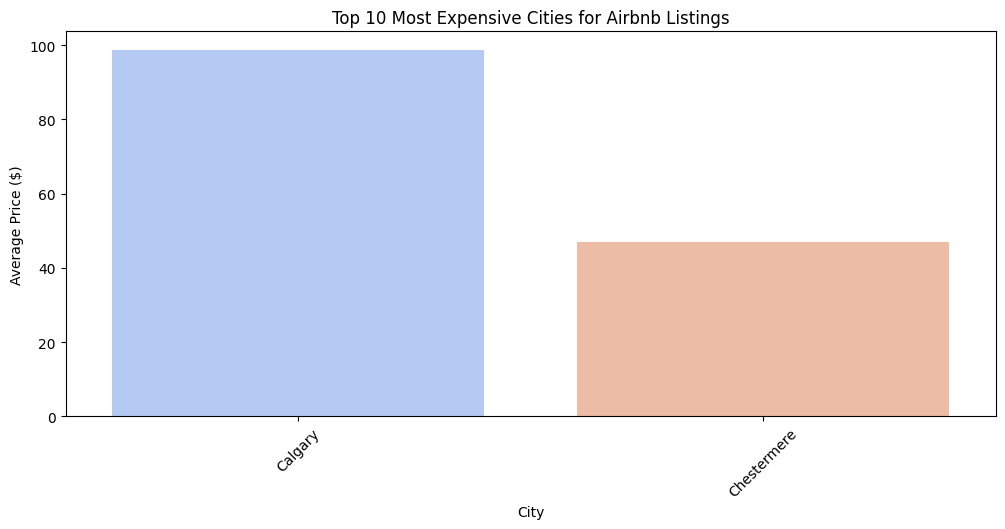

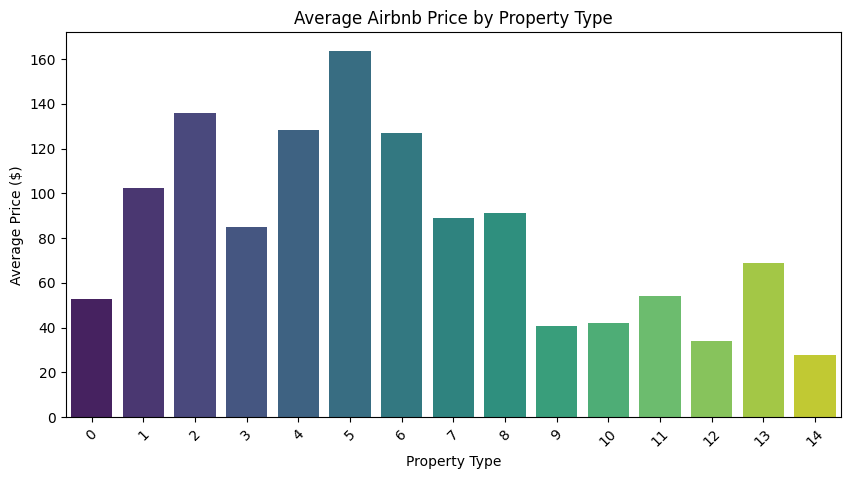

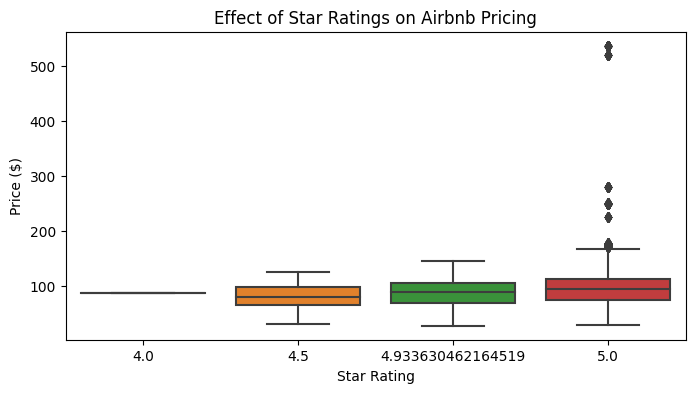


 Model Performance:
 Mean Absolute Error (MAE): 11.16
 Root Mean Squared Error (RMSE): 18.49
 R² Score: 0.90


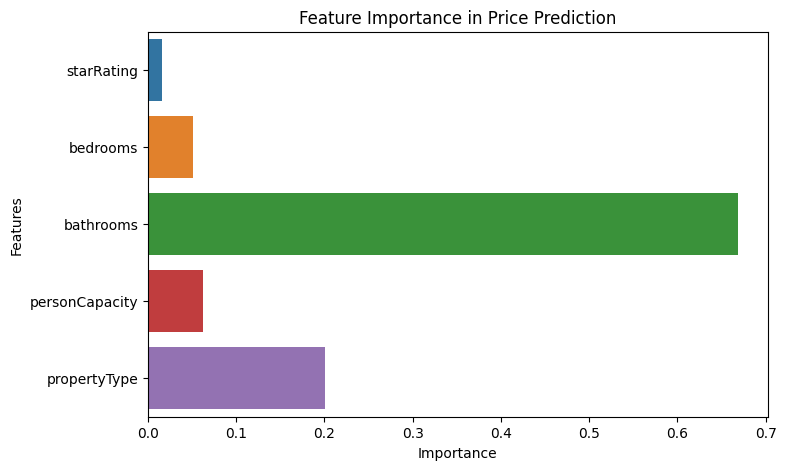

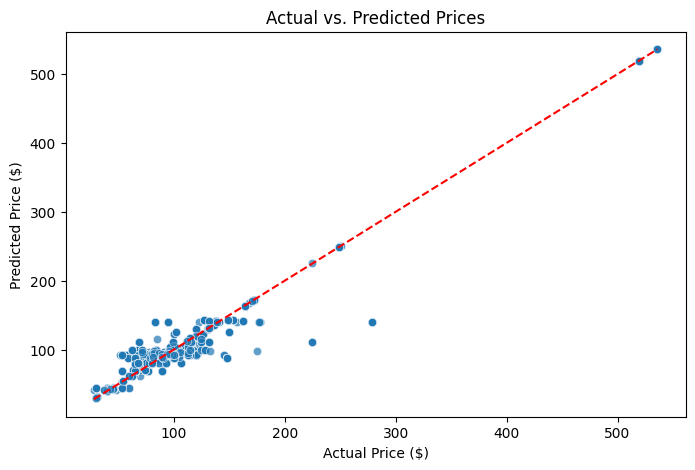

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from textblob import TextBlob

# Ignore warnings for clean output
import warnings
warnings.filterwarnings("ignore")

# Define dataset path
dataset_path = "/kaggle/input/tensorlabs-2025-internships"

### 1 Load the datasets ###
def load_data():
    try:
        property_df = pd.read_csv(f"{dataset_path}/Detailed_Property.csv")
        reviews_df = pd.read_csv(f"{dataset_path}/Property_Reviews.csv")
        places_df = pd.read_csv(f"{dataset_path}/property_by_place.csv")
        return property_df, reviews_df, places_df
    except FileNotFoundError as e:
        print("Error: One or more dataset files not found.")
        raise e

# Load data
property_df, reviews_df, places_df = load_data()

### 2 Data Preprocessing ###
places_df.rename(columns={"id": "property_id"}, inplace=True)

df = property_df.merge(places_df, on="property_id", how="left")
df = df.merge(reviews_df, on="property_id", how="left")

df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], errors='ignore', inplace=True)

df["price"] = df["price"].astype(str).str.replace(r"[^\d.]", "", regex=True)
df["price"] = pd.to_numeric(df["price"], errors="coerce")

df["starRating"].fillna(df["starRating"].mean(), inplace=True)
df["price"].fillna(df["price"].median(), inplace=True)
df.dropna(subset=['bedrooms', 'bathrooms', 'personCapacity'], inplace=True)

if "propertyType" in df.columns:
    label_encoder = LabelEncoder()
    df["propertyType"] = label_encoder.fit_transform(df["propertyType"])

### 3 Market Trend Analysis ###
if "city" in df.columns:
    avg_price_per_city = df.groupby("city")["price"].mean().sort_values(ascending=False)
    plt.figure(figsize=(12, 5))
    sns.barplot(x=avg_price_per_city.index[:10], y=avg_price_per_city.values[:10], palette="coolwarm")
    plt.xticks(rotation=45)
    plt.xlabel("City")
    plt.ylabel("Average Price ($)")
    plt.title("Top 10 Most Expensive Cities for Airbnb Listings")
    plt.show()

avg_price_property_type = df.groupby("propertyType")["price"].mean().sort_values(ascending=False)
plt.figure(figsize=(10, 5))
sns.barplot(x=avg_price_property_type.index, y=avg_price_property_type.values, palette="viridis")
plt.xticks(rotation=45)
plt.xlabel("Property Type")
plt.ylabel("Average Price ($)")
plt.title("Average Airbnb Price by Property Type")
plt.show()

plt.figure(figsize=(8, 4))
sns.boxplot(data=df, x="starRating", y="price")
plt.xlabel("Star Rating")
plt.ylabel("Price ($)")
plt.title("Effect of Star Ratings on Airbnb Pricing")
plt.show()

### 4 Sentiment Analysis ###
if "review_text" in df.columns:
    df["sentiment_score"] = df["review_text"].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=df["sentiment_score"], y=df["price"], alpha=0.5)
    plt.xlabel("Sentiment Score (Negative to Positive)")
    plt.ylabel("Price ($)")
    plt.title("Effect of Guest Sentiment on Pricing")
    plt.show()

### 5 Machine Learning Model (Predicting Price) ###
features = ['starRating', 'bedrooms', 'bathrooms', 'personCapacity', 'propertyType']
df = df.dropna(subset=features + ['price'])

X = df[features]
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=200, max_depth=15, min_samples_split=5, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

### 6 Model Evaluation ###
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n Model Performance:")
print(f" Mean Absolute Error (MAE): {mae:.2f}")
print(f" Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f" R² Score: {r2:.2f}")

plt.figure(figsize=(8, 5))
sns.barplot(x=model.feature_importances_, y=features)
plt.title("Feature Importance in Price Prediction")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title("Actual vs. Predicted Prices")
plt.xlabel("Actual Price ($)")
plt.ylabel("Predicted Price ($)")
plt.show()
